In [36]:
import numpy as np
import pandas as pd

a= pd.read_excel(io="air.xlsx")

In [37]:
a['Month'], a['Year'] = a['sampling_date'].str.split('-', 1).str

In [38]:
a.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


In [39]:
a['date'] = pd.to_datetime(a['date'],format='%Y-%m-%d') 

In [40]:
a['year'] = a['date'].dt.year

In [41]:
a['month'] = a['date'].dt.month # year

In [42]:
#a=a.drop(["Year","Month"],1)
a=a.drop(["stn_code","sampling_date","agency","location_monitoring_station"],1)

In [43]:
a.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,Month,Year,year,month
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,1990-02-01,February,M021990,1990.0,2.0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,NaN,NaN,NaN,1990-02-01,February,M021990,1990.0,2.0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,1990-02-01,February,M021990,1990.0,2.0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,1990-03-01,March,M031990,1990.0,3.0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,NaN,NaN,NaN,1990-03-01,March,M031990,1990.0,3.0


In [44]:
a.dropna(subset=['month'], inplace=True)

In [45]:
a["spm"].fillna((a["spm"].mean()),inplace=True)
a["rspm"].fillna((a["rspm"].mean()),inplace=True)
a["no2"].fillna((a["no2"].mean()),inplace=True)
a["so2"].fillna((a["so2"].mean()),inplace=True)
a["pm2_5"].fillna((a["pm2_5"].mean()),inplace=True)

In [46]:
from collections import Counter
Counter(a['type'])

Counter({'Residential, Rural and other Areas': 179013,
         'Industrial Area': 96089,
         nan: 5390,
         'Sensitive Area': 8979,
         'Industrial Areas': 51747,
         'Residential and others': 86791,
         'Sensitive Areas': 5536,
         'Industrial': 233,
         'Residential': 158,
         'RIRUO': 1304,
         'Sensitive': 495})

In [47]:
a['type'] = a["type"].replace(np.NaN, 'Residential and others')

In [48]:
#Function to calculate so2 individual pollutant index(si)
def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
a['si']=a['so2'].apply(calculate_si)

In [49]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
a['ni']=a['no2'].apply(calculate_ni)


In [50]:
#Function to calculate no2 individual pollutant index(rpi)
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
     rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
     rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
     rpi=300+(rpi-120)*(100/130)
    else:
     rpi=400+(rpi-250)*(100/130)
    return rpi
a['rpi']=a['rspm'].apply(calculate_si)

In [51]:
#Function to calculate no2 individual pollutant index(spi)
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi
a['spi']=a['spm'].apply(calculate_spi)

In [52]:
#function to calculate the air quality index (AQI) of every data value
#its is calculated as per indian govt standards
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi
a['AQI']=a.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)

In [53]:
a.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,Month,Year,year,month,si,ni,rpi,spi,AQI
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,6.000,21.750,109.61103,180.52232,180.52232
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,3.875,8.750,109.61103,180.52232,180.52232
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,7.750,35.625,109.61103,180.52232,180.52232
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,108.833091,220.78348,40.791467,1990-03-01,March,M031990,1990.0,3.0,7.875,18.375,109.61103,180.52232,180.52232
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,108.833091,220.78348,40.791467,1990-03-01,March,M031990,1990.0,3.0,5.875,9.375,109.61103,180.52232,180.52232


In [54]:
a.isna().sum()

state            0
location         0
type             0
so2              0
no2              0
rspm             0
spm              0
pm2_5            0
date             0
Month       164158
Year        265551
year             0
month            0
si               0
ni               0
rpi              0
spi              0
AQI              0
dtype: int64

In [55]:
X = a.iloc[:,3:8]   # date column
Z= a.iloc[:,11:15]
Y = a.iloc[:,-1]

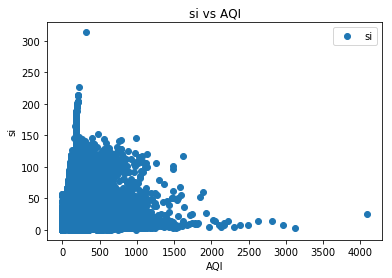

In [56]:
# now we will create a scatter plot to see how the various factors affect the AQI
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

a.plot(x='AQI', y='si', style='o')  
plt.title('si vs AQI')  
plt.xlabel('AQI')  
plt.ylabel('si')  
plt.show()

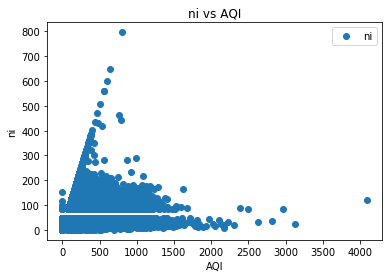

In [57]:
a.plot(x='AQI', y='ni', style='o')  
plt.title('ni vs AQI')  
plt.xlabel('AQI')  
plt.ylabel('ni')  
plt.show()

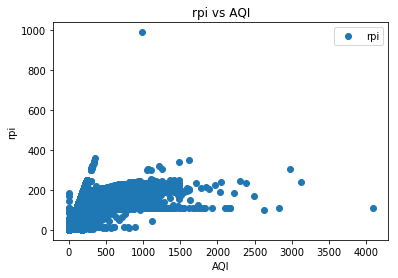

In [58]:
a.plot(x='AQI', y='rpi', style='o')  
plt.title('rpi vs AQI')  
plt.xlabel('AQI')  
plt.ylabel('rpi')  
plt.show()

NameError: name 'c' is not defined

In [59]:
from sklearn.linear_model import LinearRegression # to build linear regression model
from sklearn.model_selection import train_test_split

Ztrain, Ztest, Ytrain, Ytest = train_test_split(Z, Y, train_size=0.80, random_state=20)

In [60]:
from sklearn.preprocessing import StandardScaler

Ztest[["si","ni","rpi","spi"]] = StandardScaler().fit_transform(Ztest[["si","ni","rpi","spi"]])
Ztrain[["si","ni","rpi","spi"]] = StandardScaler().fit_transform(Ztrain[["si","ni","rpi","spi"]])

KeyError: "['rpi' 'spi'] not in index"

In [ ]:
regressor = LinearRegression()  
regressor.fit(Ztrain, Ytrain)


In [ ]:
coeff_df = pd.DataFrame(regressor.coef_, Z.columns, columns=['Coefficient'])  
coeff_df

In [ ]:
y_pred = regressor.predict(Ztest)
df = pd.DataFrame({'Actual': Ytest, 'Predicted': y_pred})
df.head(25)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Ytest, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Ytest, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Ytest, y_pred)))

In [ ]:
a["AQI"].min()

In [ ]:
a.plot(x='AQI', y='year', style='o')  
plt.title('rpi vs AQI')  
plt.xlabel('AQI')  
plt.ylabel('year')  
plt.show()

In [354]:
a['AQI']=a['AQI'].round(decimals=2)

In [369]:

def AQI_index (a):
    if a['AQI'] >=0.00 and a['AQI'] <=50.00 :
      return 'Good'
    if a['AQI'] >50.00 and a['AQI'] <=100.00 :
      return 'Moderate'
    if a['AQI'] >100.00 and a['AQI'] <=150.00 :
      return 'Unhealthy for Senstive Groups'
    if a['AQI'] >150.00 and a['AQI'] <=200.00 :
      return 'Unhealthy'
    if a['AQI'] >200.00 and a['AQI'] <=250.00 :
      return 'Very Unhealthy'
    if a['AQI'] >250.00 :
      return 'Hazardous'
  

In [370]:
a['AQI Category']=a.apply (lambda air: AQI_index(air), axis=1)

In [371]:
a['AQI Category']=a['AQI Category'].astype(str)

In [372]:
from sklearn.preprocessing import LabelEncoder
a['AQI_encoded'] = LabelEncoder().fit_transform(a['AQI Category'])
a[['AQI Category', 'AQI_encoded']] # special syntax to get just these two columns

,AQI Category,AQI_encoded
0,Unhealthy,3
1,Unhealthy,3
2,Unhealthy,3
3,Unhealthy,3
4,Unhealthy,3
5,Unhealthy,3
6,Unhealthy,3
7,Unhealthy,3
8,Unhealthy,3
9,Unhealthy,3


In [374]:
a.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,Month,Year,year,month,si,ni,rpi,spi,AQI,AQI Category,AQI_encoded
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,6.000,21.750,109.61103,180.52232,180.52,Unhealthy,3
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,3.875,8.750,109.61103,180.52232,180.52,Unhealthy,3
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,108.833091,220.78348,40.791467,1990-02-01,February,M021990,1990.0,2.0,7.750,35.625,109.61103,180.52232,180.52,Unhealthy,3
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,108.833091,220.78348,40.791467,1990-03-01,March,M031990,1990.0,3.0,7.875,18.375,109.61103,180.52232,180.52,Unhealthy,3
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,108.833091,220.78348,40.791467,1990-03-01,March,M031990,1990.0,3.0,5.875,9.375,109.61103,180.52232,180.52,Unhealthy,3


In [375]:
a["AQI_encoded"].unique()

array([3, 4, 5, 1, 0, 2], dtype=int64)

In [376]:
a["AQI Category"].unique()

array(['Unhealthy', 'Unhealthy for Senstive Groups', 'Very Unhealthy',
       'Hazardous', 'Good', 'Moderate'], dtype=object)

In [377]:
from collections import Counter

c = Counter(a["AQI Category"] )

print( c.items() )

dict_items([('Unhealthy', 276541), ('Unhealthy for Senstive Groups', 58126), ('Very Unhealthy', 19757), ('Hazardous', 48303), ('Good', 17060), ('Moderate', 15948)])


In [368]:
rslt_df = a.loc[a['AQI Category'] == 'None']
print(rslt_df["AQI"])

1302      50.88
1312      50.38
155440    50.75
156800    50.12
162752    50.74
162757    50.51
162758    50.18
162759    50.18
162764    50.85
162768    50.62
162876    50.83
162995    50.42
163030    50.55
163056    50.55
163245    50.14
163316    50.41
163317    50.41
163325    50.41
209424    50.25
210974    50.62
219796    50.03
262601    50.42
262646    50.42
262681    50.83
262682    50.42
262690    50.42
262801    50.42
262812    50.42
262815    50.83
262853    50.83
270679    50.84
271072    50.41
271081    50.41
271183    50.41
278988    50.83
279815    50.88
290559    50.42
332238    50.42
333016    50.62
333414    50.83
333625    50.88
333727    50.42
345305    50.84
350776    50.62
352056    50.42
352442    50.42
352443    50.83
352549    50.42
352982    50.83
353011    50.62
353016    50.62
353206    50.42
388244    50.42
415159    50.38
415225    50.88
426440    50.42
426641    50.42
Name: AQI, dtype: float64


In [399]:
A= a["AQI_encoded"]
X2 =a.iloc[:,[3,12,13,14]]

In [398]:
B.head()

0    3
1    3
2    3
3    3
4    3
Name: AQI_encoded, dtype: int32

In [400]:
Atrain, Atest, X2train, X2test = train_test_split(A, X2, train_size=0.80, random_state=20)

C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [443]:
from sklearn import tree

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=4, min_samples_leaf=4)
clf_gini.fit(X2train,Atrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [444]:

loanTree.fit(X2train,Atrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [445]:
predLoan = loanTree.predict(X2test)
from sklearn.metrics import confusion_matrix,classification_report,precision_score
print(classification_report(Atest,predLoan))

              precision    recall  f1-score   support

           0       1.00      0.04      0.07      3419
           1       0.00      0.00      0.00      9662
           2       0.00      0.00      0.00      3137
           3       0.64      1.00      0.78     55313
           4       0.36      0.00      0.00     11601
           5       0.00      0.00      0.00      4015

   micro avg       0.64      0.64      0.64     87147
   macro avg       0.33      0.17      0.14     87147
weighted avg       0.49      0.64      0.50     87147



C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\imsid\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [447]:
print("Accuracy:",metrics.accuracy_score(Atest, predLoan))

Accuracy: 0.6361664773314055


In [448]:
labels = ['Good','Hazardous','Moderate','Unhealthy','Unhealthy for Senstive Groups', 'Very Unhealthy']

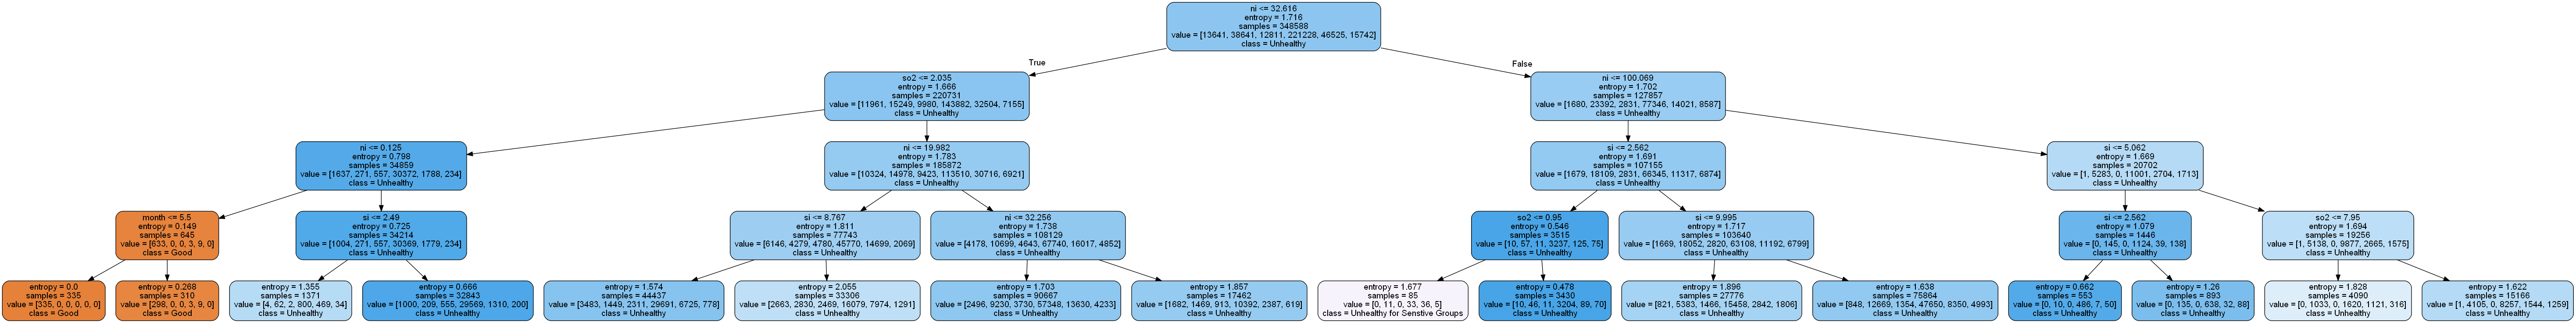

In [449]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot
features = list(X2.columns)
# features
dot_data = StringIO()  
export_graphviz(loanTree, out_file=dot_data,feature_names=features,filled=True,rounded=True,class_names=labels)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

In [456]:
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=26)

#Train the model using the training sets
knn.fit(X2train, Atrain)

#Predict the response for test dataset
y_pred = knn.predict(X2test)

In [457]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Atest, y_pred))

Accuracy: 0.6411695181704476
